In [ ]:
# Compute edit distance with WFST

# https://github.com/revdotcom/fstalign/blob/develop/src/fstalign.cpp#L197
# https://www.statmt.org/wmt16/pdf/W16-2324.pdf
# https://aclanthology.org/P14-2102.pdf
# https://github.com/k2-fsa/k2/issues/746

In [2]:
import sys
sys.path.insert(0,'/exp/rhuang/meta/icefall/egs/librispeech/ASR/conformer_ctc2_noseg')
sys.path.insert(0,'/exp/rhuang/meta/k2/k2/python')
sys.path.insert(0,'/exp/rhuang/meta/k2/temp.linux-x86_64-cpython-310/lib')
sys.path.insert(0,'/exp/rhuang/meta/icefall')

In [38]:
import k2
import sentencepiece as spm
import torch
import pywrapfst as openfst
from icefall.decode import get_lattice, one_best_decoding
from icefall.utils import get_alignments, get_texts, get_texts_with_timestamp
from data_long_dataset import *
from pathlib import Path

In [4]:
sp = spm.SentencePieceProcessor()
sp.load("/exp/rhuang/meta/icefall/egs/librispeech/ASR/data/lang_bpe_500/bpe.model")

True

In [5]:
texts = ["I DO NOT WANT TO INCUR", "THERE WAS LOVERS LIKE DOGS", "RED APP I"]
word_ids_list = sp.encode(texts, out_type=int)
word_ids_list

[[19, 100, 69, 414, 10, 15, 18, 79],
 [153, 33, 370, 23, 3, 231, 100, 52, 3],
 [49, 12, 5, 145, 19]]

# Compute edit distance with WFST

In [13]:
word_ids_list1 = [24, 102, 70, 393, 12, 17, 19, 80]
word_ids_list2 = [24, 102, 392, 70, 12, 19, 80]

# word_ids_list1 = list(range(800, 900)) + [24, 102, 70, 393, 12, 17, 19, 80] + list(range(800, 900))
# word_ids_list2 = [24, 102, 392, 70, 12, 19, 80]

# word_ids_list1 = [77] * 100 + [24, 102, 70, 393, 12, 17, 19, 80] + [77] * 100
# word_ids_list2 = [24, 102, 392, 70, 12, 19, 80]

In [150]:
# graph1 = k2.ctc_graph([word_ids_list1], modified=False, device='cpu')[0]
# graph2 = k2.ctc_graph([word_ids_list2], modified=False, device='cpu')[0]

# graph1 = k2.linear_fsa([word_ids_list1], device='cpu')[0]
# graph2 = k2.linear_fsa([word_ids_list2], device='cpu')[0]

graph1 = k2.linear_fst(labels=[word_ids_list1], aux_labels=[word_ids_list1])[0]
graph2 = k2.linear_fst(labels=[word_ids_list2], aux_labels=[word_ids_list2])[0]

In [21]:
k2.to_dot(graph1)

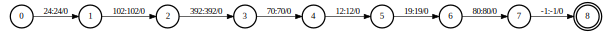

In [22]:
k2.to_dot(graph2)

In [6]:
def get_linear_fst(word_ids_list, blank_id=0, max_symbol_id=1000, input_side=True, return_str=False):
    graph = k2.linear_fst(labels=[word_ids_list], aux_labels=[word_ids_list])[0]

    max_symbol_id += 1

    c_str = k2.to_str_simple(graph)
    arcs = c_str.strip().split("\n")
    arcs = [x.strip() for x in arcs if len(x.strip()) > 0]
    final_state = int(arcs[-1])

    arcs = arcs[:-1]
    arcs = [tuple(map(int, a.split())) for a in arcs]

    new_arcs = []
    for i, (ss, ee, l1, l2, w) in enumerate(arcs):
        if l1 > 0:
            # substitution
            if input_side:
                new_arcs.append([ss, ee, max_symbol_id, l2, -1])
            else:
                new_arcs.append([ss, ee, l1, max_symbol_id, -1])
            
            # deletion
            new_arcs.append([ss, ee, l1, blank_id, -2])
        
        # insertion
        if input_side:
            new_arcs.append([ss, ss, max_symbol_id, blank_id, -2])
        else:
            new_arcs.append([ss, ss, blank_id, max_symbol_id, -2])
    
    new_arcs = arcs + new_arcs
    new_arcs.append([final_state])

    new_arcs = sorted(new_arcs, key=lambda arc: arc[0])
    new_arcs = [[str(i) for i in arc] for arc in new_arcs]
    new_arcs = [" ".join(arc) for arc in new_arcs]
    new_arcs = "\n".join(new_arcs)

    if return_str:
        return new_arcs
    else:
        fst = k2.Fsa.from_str(new_arcs, acceptor=False)
        fst = k2.arc_sort(fst)
        return fst

In [14]:
graph1 = get_linear_fst(word_ids_list1, max_symbol_id=1000, blank_id=0, input_side=False, return_str=False)
graph2 = get_linear_fst(word_ids_list2, max_symbol_id=1000, blank_id=0, input_side=True, return_str=False)

In [37]:
# print(graph1)
# graph1.arcs.values()

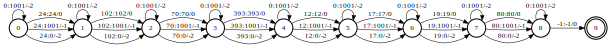

In [15]:
k2.to_dot(graph1)

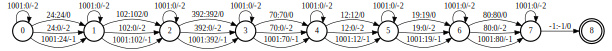

In [16]:
k2.to_dot(graph2)

In [134]:
rs = k2.compose(graph1, graph2, treat_epsilons_specially=True)
rs = k2.connect(rs)
rs = k2.remove_epsilon_self_loops(rs)
# rs = k2.arc_sort(rs)
rs = k2.top_sort(rs)  # top-sort is needed: https://github.com/k2-fsa/k2/issues/746#issuecomment-856503238

rs.shape, rs.num_arcs

((1673, None), 6260)

In [113]:
rs.arcs.values()

tensor([[          0,           1,          24, -1073741824],
        [          0,           3,          24,           0],
        [          0,           3,          24, -1073741824],
        ...,
        [         69,          71,          80, -1069547520],
        [         70,          71,           0, -1069547520],
        [         71,          72,          -1,           0]],
       dtype=torch.int32)

In [103]:
rs.labels

tensor([ 24,  24,   0,  24,  24, 102, 102,   0, 102, 102,   0,  24,  24,   0,
        102, 102,   0,  70,  70,   0, 102, 102,   0,  70,  70,   0,  24,  24,
          0,  70,  70,  70,  70,   0,  70,  70,   0, 393, 393,   0, 393, 393,
          0, 102, 102,   0, 393, 393,   0,  24,  24,   0, 393, 393,   0, 393,
        393,   0,  70,  70,   0,  12,  12,   0,  12,  12,  12,  12,   0,  12,
         12,   0, 102, 102,   0,  12,  12,   0,  24,  24,   0,  12,  12,   0,
        393, 393,   0,  12,  12,   0,  70,  70,   0,  17,  17,   0,  17,  17,
          0,  17,  17,   0,  17,  17,   0, 102, 102,   0,  17,  17,   0,  24,
         24,   0,  17,  17,   0, 393, 393,   0,  12,  12,   0,  17,  17,   0,
         70,  70,   0,  19,  19,   0,  19,  19,   0,  19,  19,  19,  19,   0,
         19,  19,   0,  19,  19,   0, 102, 102,   0,  19,  19,   0,  24,  24,
          0,  19,  19, 393,  12,  17,  19,  70,   0,  80,  80,   0,  80,  80,
          0,  80,  80,   0,  80,  80,  80,  80,   0,  80,  80,  

In [ ]:
k2.to_dot(rs)

In [136]:
rs_vec = k2.create_fsa_vec([rs])

# best_path = one_best_decoding(
#     lattice=rs_vec,
#     use_double_scores=True,
# )

best_path = k2.shortest_path(rs_vec, use_double_scores=True)
best_path.shape, best_path.num_arcs

((1, None, None), 209)

In [116]:
rs.properties
rs.properties_str

'"Valid|Nonempty|TopSorted|TopSortedAndAcyclic|MaybeAccessible|MaybeCoaccessible"'

In [ ]:
k2.to_dot(best_path[0])

In [118]:
hyps = get_texts(best_path)
print(f"hyps={hyps}")

hyps=[[24, 102, 392, 70, 12, 19, 80]]


In [131]:
edit_distance = best_path.get_tot_scores(log_semiring=False, use_double_scores=False) / 2
edit_distance

tensor([-20003.])

# Compute edit distance for the alignment results and `arange`

In [6]:
f="/exp/rhuang/meta/icefall/egs/librispeech/ASR/conformer_ctc2_noseg/exp/exp_seed_small_model5/ali_-18/7327/93283/93283.pt"
rs = torch.load(f)
rs.keys()

dict_keys(['meta_data', 'hyps', 'timestamps', 'output_frame_offset'])

In [7]:
hyps = rs['hyps']
timestamps = rs['timestamps']
output_frame_offset = rs['output_frame_offset']
meta_data = rs['meta_data']

In [8]:
meta_data

{'book_id': ['3005'],
 'chapter_id': ['93283'],
 'speaker_id': ['7327'],
 'audio_path': ['LibriSpeechOriginal/LibriSpeech/mp3/7327/93283/93283.mp3'],
 'text_path': ['LibriSpeechAligned/LibriSpeech/books/ascii/3005/3005.txt']}

In [9]:
len(hyps), len(timestamps), len(output_frame_offset), len(meta_data)
# This many segments of (segment_size - overlap) seconds, e.g., 28 seconds

(23, 23, 23, 5)

In [10]:
i = 0
print(hyps[i])
print(timestamps[i])
print(output_frame_offset[i])

[2882, 2883, 42850, 42851, 42852, 42853, 42854, 42861, 7984, 7987, 7980, 7984, 43408, 43409, 43410, 43411, 43412, 25750, 25752, 44797, 44801, 44804, 3812, 3820, 9481, 100, 101, 103, 104, 105, 106, 107, 108, 109, 110, 34953, 20004, 20011, 20013, 20014, 22127, 22128, 24383, 24384, 24385, 24386, 24387, 24388, 24389, 24390, 24391, 24392, 24393, 24394, 24395, 24396, 24397, 24398, 24399, 24400, 24401, 24402]
[17, 40, 45, 53, 59, 64, 66, 102, 124, 156, 160, 169, 181, 183, 186, 189, 196, 220, 226, 240, 253, 264, 270, 307, 312, 362, 366, 422, 429, 435, 439, 441, 462, 467, 475, 500, 508, 543, 557, 610, 613, 622, 628, 635, 639, 643, 647, 657, 660, 664, 676, 679, 682, 688, 706, 710, 716, 720, 725, 729, 735, 744]
tensor(0, dtype=torch.int32)


In [11]:
i = 1
print(hyps[i])
print(timestamps[i])
print(output_frame_offset[i])

[24395, 24396, 24397, 24398, 24399, 24400, 24401, 24402, 24403, 24404, 24405, 24406, 24407, 24408, 24409, 24410, 24411, 24412, 24413, 24414, 24415, 24416, 24417, 24418, 24419, 24420, 24421, 24422, 24423, 24424, 24425, 24426, 24427, 24428, 24429, 24430, 24431, 24432, 24433, 24434, 24435, 24436, 24438, 24440, 24441, 24442, 24444, 24445, 24446, 24447, 24448, 24449, 24450, 24451, 24452, 24453, 24454, 24455, 24456, 24457, 24458, 24459, 24460, 24461, 24462, 24463, 24465, 24466, 24467, 24468, 24469, 24470, 24472, 24473, 24474, 24475, 24476, 24477, 24478, 24479, 24480, 24481, 24482, 24483, 24484, 24485, 24486, 24487, 24488, 24489]
[6, 10, 16, 20, 25, 29, 35, 61, 67, 71, 78, 81, 100, 111, 123, 127, 132, 141, 170, 180, 184, 189, 192, 202, 205, 209, 217, 219, 223, 226, 233, 238, 244, 270, 274, 278, 302, 305, 308, 320, 324, 329, 337, 351, 400, 403, 411, 425, 429, 437, 441, 445, 447, 451, 464, 468, 472, 477, 486, 489, 499, 502, 508, 513, 517, 554, 560, 563, 567, 572, 582, 587, 601, 611, 617, 622, 6

In [13]:
torch.Tensor(timestamps[i]) + output_frame_offset[i]

tensor([ 706.,  710.,  716.,  720.,  725.,  729.,  735.,  761.,  767.,  771.,
         778.,  781.,  800.,  811.,  823.,  827.,  832.,  841.,  870.,  880.,
         884.,  889.,  892.,  902.,  905.,  909.,  917.,  919.,  923.,  926.,
         933.,  938.,  944.,  970.,  974.,  978., 1002., 1005., 1008., 1020.,
        1024., 1029., 1037., 1051., 1100., 1103., 1111., 1125., 1129., 1137.,
        1141., 1145., 1147., 1151., 1164., 1168., 1172., 1177., 1186., 1189.,
        1199., 1202., 1208., 1213., 1217., 1254., 1260., 1263., 1267., 1272.,
        1282., 1287., 1301., 1311., 1317., 1322., 1328., 1335., 1340., 1347.,
        1376., 1379., 1382., 1389., 1392., 1394., 1397., 1401., 1404., 1408.])

In [10]:
def get_linear_fst(word_ids_list, blank_id=0, max_symbol_id=1000, is_left=True, return_str=False):
    graph = k2.linear_fst(labels=[word_ids_list], aux_labels=[word_ids_list])[0]

    max_symbol_id += 1

    c_str = k2.to_str_simple(graph)
    arcs = c_str.strip().split("\n")
    arcs = [x.strip() for x in arcs if len(x.strip()) > 0]
    final_state = int(arcs[-1])

    arcs = arcs[:-1]
    arcs = [tuple(map(int, a.split())) for a in arcs]

    max_symbol_id = max(max_symbol_id, len(arcs) + 10)

    new_arcs = []
    # left: ground-truth (from arange)
    # right: hypothesis (from alignment)
    for i, (ss, ee, l1, l2, w) in enumerate(arcs):
        if l1 > 0:
            # substitution
            if is_left:
                new_arcs.append([ss, ee, l1, max_symbol_id, -1])
            else:
                new_arcs.append([ss, ee, max_symbol_id, i+1, -1])
            
            # deletion
            new_arcs.append([ss, ee, l1, blank_id, -2])
        
        # insertion
        if is_left:
            new_arcs.append([ss, ss, blank_id, max_symbol_id, -2])
        else:
            new_arcs.append([ss, ss, max_symbol_id, blank_id, -2])
    
    if not is_left:
        arcs = [(ss, ee, l1, i+1 if l2 >= 0 else l2, w) for i, (ss, ee, l1, l2, w) in enumerate(arcs)]

    new_arcs = arcs + new_arcs
    new_arcs.append([final_state])

    new_arcs = sorted(new_arcs, key=lambda arc: arc[0])
    new_arcs = [[str(i) for i in arc] for arc in new_arcs]
    new_arcs = [" ".join(arc) for arc in new_arcs]
    new_arcs = "\n".join(new_arcs)

    if return_str:
        return new_arcs
    else:
        fst = k2.Fsa.from_str(new_arcs, acceptor=False)
        fst = k2.arc_sort(fst)
        return fst

In [11]:
def get_range_without_outliers(my_list, scan_range=100, outlier_threshold=60):
    # remove outliers
    # given a list of integers in my_list in ascending order, find the range without outliers
    # outliers: a number that is outlier_threshold smaller/larger than its neighbors

    assert len(my_list) > 10

    scan_range = min(scan_range, int(len(my_list)/2) - 1)
    
    left = [i+1 for i in range(0, scan_range) if my_list[i+1] - my_list[i] > outlier_threshold]
    right = [i-1 for i in range(-scan_range, 0) if my_list[i] - my_list[i-1] > outlier_threshold]
    left = left[-1] if len(left) > 0 else 0
    right = right[0] if len(right) > 0 else -1
    left = my_list[left]
    right = my_list[right]
    return left, right

my_list = [150] + list(range(200,1000)) + [1105]
print(my_list)
get_range_without_outliers(my_list)

[150, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398,

(150, 999)

In [12]:
class WordCounter: 
    def __init__(self, val=0): 
        self.counter1 = val
    def f1(self): 
        self.counter1 += 1; return self.counter1


def get_aligned_list(hyps_list, my_hyps_min=None, my_hyps_max=None):
    my_hyps_ids = sorted([w for hyp in hyps_list for w in hyp])

    _my_hyps_min, _my_hyps_max = get_range_without_outliers(my_hyps_ids, scan_range=100, outlier_threshold=60)
    my_hyps_min = _my_hyps_min if my_hyps_min is None else max(my_hyps_min - 10, 0)
    my_hyps_max = _my_hyps_max if my_hyps_max is None else my_hyps_max + 10
        
    max_symbol_id = max(my_hyps_ids) + 100   # use this symbol to mark the chunk boundaries
    ids_list1 = list(range(my_hyps_min, my_hyps_max + 1))
    ids_list2 = [item for sublist in hyps_list for item in ([max_symbol_id] + sublist)]
    ids_list2 = ids_list2[1:]

    graph1 = get_linear_fst(ids_list1, max_symbol_id=max_symbol_id+1, blank_id=0, is_left=True, return_str=False)
    graph2 = get_linear_fst(ids_list2, max_symbol_id=max_symbol_id+1, blank_id=0, is_left=False, return_str=False)

    rs = k2.compose(graph1, graph2, treat_epsilons_specially=True)
    rs = k2.connect(rs)
    rs = k2.remove_epsilon_self_loops(rs)
    # rs = k2.arc_sort(rs)
    rs = k2.top_sort(rs)  # top-sort is needed: https://github.com/k2-fsa/k2/issues/746#issuecomment-856503238
    # print("Composed graph size: ", rs.shape, rs.num_arcs)

    rs_vec = k2.create_fsa_vec([rs])
    best_paths = k2.shortest_path(rs_vec, use_double_scores=True)
    # best_paths.shape, best_paths.num_arcs

    best_paths = k2.top_sort(best_paths)
    best_paths = k2.arc_sort(best_paths)

    rs_list1 = best_paths[0].labels.tolist()
    rs_list2 = best_paths[0].aux_labels.tolist()
    rs_list2_ = [ids_list2[i-1] if i > 0 else None for i in rs_list2]
    for l1, l2 in zip(rs_list1, rs_list2_):
        if l1 == l2:
            break
    rs_my_hyps_min = l1
    
    for l1, l2 in zip(reversed(rs_list1), reversed(rs_list2_)):
        if l1 == l2 and l1 > 0:
            break
    rs_my_hyps_max = l1

    # adjust rs_list2 for each chunk
    word_counter = WordCounter(-1)
    i_mapping = {word_counter.f1() : i - 1 for sublist in hyps_list for i, item in enumerate([max_symbol_id] + sublist)}
    rs_list2 = [i_mapping[i] if i in i_mapping else None for i in rs_list2]

    # print("Best path range: ", rs_my_hyps_min, rs_my_hyps_max)

    return best_paths, rs_list1, rs_list2, rs_list2_, max_symbol_id, rs_my_hyps_min, rs_my_hyps_max


In [33]:
def align_long_text(rs, num_segments_per_chunk=5, neighbor_threshold=5):
    hyps = rs['hyps']
    timestamps = rs['timestamps']
    output_frame_offset = rs['output_frame_offset'].tolist()
    meta_data = rs['meta_data']

    alignment_results = dict()

    my_hyps_max_prev = None
    for i in range(0, len(hyps), num_segments_per_chunk):
        print(f"Processing chunks: {i} to {i+num_segments_per_chunk}")
        hyps_list = hyps[i: i+num_segments_per_chunk]
        best_paths, rs_list1, rs_list2, rs_list2_, max_symbol_id, rs_my_hyps_min, rs_my_hyps_max = get_aligned_list(hyps_list, my_hyps_min=my_hyps_max_prev)
        
        # TODO: put best_paths into alignment_results: word_index (in the long text) => frame_index (in the long audio)
        j = i
        for l1, l2, l2_ in zip(rs_list1, rs_list2, rs_list2_):
            # l1: word index in the long text
            # l2: index in the chunk
            # l2_: word index in the long text
            if l1 == l2_ and l1 > 0:
                if l2 >= len(timestamps[j]):
                    print(f"Warning: [{j}][{l1, l2, l2_}]")
                alignment_results[l1] = timestamps[j][l2] + output_frame_offset[j]
            if l2 == -1 and l2_ == max_symbol_id:
                j += 1

        my_hyps_max_prev = rs_my_hyps_max
    
    # TODO: post-process
    # each aligned word should have a neighborhood of at least neighbor_threshold words

    return alignment_results
        

In [34]:
my_hyps = [hyps[0], hyps[1], hyps[2], hyps[3], hyps[4]]
best_paths, rs_list1, rs_list2, rs_list2_, max_symbol_id, rs_my_hyps_min, rs_my_hyps_max = get_aligned_list(my_hyps)
best_paths.shape, best_paths.num_arcs, max_symbol_id, rs_my_hyps_min, rs_my_hyps_max

((1, None, None), 446, 44904, 24383, 24763)

In [19]:
# k2.to_dot(best_paths[0])

In [68]:
rs_list2

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 -1,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 -1,
 42,
 -1,
 43,
 44,
 45,
 -1,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 -1,
 66,
 67,
 68,
 69,
 70,
 71,
 -1,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 -1,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 -1,
 10,
 11,
 12,
 13,
 14,
 -1,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 -1,
 39,
 -1,
 40,
 41,
 42,


In [14]:
# hyps = get_texts(best_path)
# print(f"hyps={hyps}")

# print(best_paths[0].labels.tolist())
# print(best_paths[0].aux_labels.tolist())

# print(*list(zip(best_paths[0].labels.tolist(), best_paths[0].aux_labels.tolist())), sep="\n")
print(*list(zip(rs_list1, rs_list2, rs_list2_)), sep="\n")

(0, 0, 2882)
(0, 1, 2883)
(0, 2, 42850)
(0, 3, 42851)
(0, 4, 42852)
(0, 5, 42853)
(0, 6, 42854)
(0, 7, 42861)
(0, 8, 7984)
(0, 9, 7987)
(0, 10, 7980)
(0, 11, 7984)
(0, 12, 43408)
(0, 13, 43409)
(0, 14, 43410)
(0, 15, 43411)
(0, 16, 43412)
(0, 17, 25750)
(0, 18, 25752)
(0, 19, 44797)
(0, 20, 44801)
(0, 21, 44804)
(0, 22, 3812)
(0, 23, 3820)
(0, 24, 9481)
(0, 25, 100)
(0, 26, 101)
(0, 27, 103)
(0, 28, 104)
(0, 29, 105)
(0, 30, 106)
(0, 31, 107)
(0, 32, 108)
(0, 33, 109)
(0, 34, 110)
(0, 35, 34953)
(0, 36, 20004)
(0, 37, 20011)
(0, 38, 20013)
(0, 39, 20014)
(0, 40, 22127)
(0, 41, 22128)
(24383, 42, 24383)
(24384, 43, 24384)
(24385, 44, 24385)
(24386, 45, 24386)
(24387, 46, 24387)
(24388, 47, 24388)
(24389, 48, 24389)
(24390, 49, 24390)
(24391, 50, 24391)
(24392, 51, 24392)
(24393, 52, 24393)
(24394, 53, 24394)
(24395, 54, 24395)
(24396, 55, 24396)
(24397, 56, 24397)
(24398, 57, 24398)
(24399, 58, 24399)
(24400, 59, 24400)
(24401, 60, 24401)
(24402, 61, 24402)
(0, -1, 44904)
(0, 0, 24395)


In [19]:
len(timestamps[4])

83

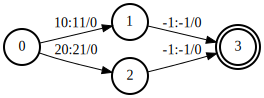

In [51]:
s = '''
0 1 10 11 0
0 2 20 21 0
1 3 -1 -1 0
2 3 -1 -1 0
3
'''
fsa = k2.Fsa.from_str(s, acceptor=False)
k2.to_dot(fsa)

In [52]:
fsa.arcs.values()

tensor([[ 0,  1, 10,  0],
        [ 0,  2, 20,  0],
        [ 1,  3, -1,  0],
        [ 2,  3, -1,  0]], dtype=torch.int32)

In [53]:
fsa.labels, fsa.aux_labels

(tensor([10, 20, -1, -1], dtype=torch.int32),
 tensor([11, 21, -1, -1], dtype=torch.int32))

In [35]:
alignment_results = align_long_text(rs, num_segments_per_chunk=5, neighbor_threshold=5)

Processing chunks: 0 to 5
Processing chunks: 5 to 10
Processing chunks: 10 to 15
Processing chunks: 15 to 20
Processing chunks: 20 to 25


In [39]:
long_dataset = LibrispeechLongAudioDataset(
    root = "/exp/rhuang/meta/icefall/egs/librispeech/ASR/download/",
    skip_loading_audio = True,
    # skip_text_normalization = True,
    # manifest_file = None,
)
long_dataset_index = {Path(long_dataset.manifest[i][0]).parent.stem: i for i in range(len(long_dataset))}  # chapter id => index

In [42]:
waveform, sample_rate, text, speaker_id, chapter_id, meta_data  = long_dataset[long_dataset_index['93283']]
text = text.split()

In [44]:
alignment_results_ = [(text[k], v*0.04) for k, v in sorted(alignment_results.items())]

In [45]:
alignment_results_

[('FOLLOWED', 25.12),
 ('THE', 25.400000000000002),
 ('CHIEF', 25.560000000000002),
 ('OF', 25.72),
 ('POLICE', 25.88),
 ('AND', 26.28),
 ('THE', 26.400000000000002),
 ('CONSTABLE', 26.560000000000002),
 ('TO', 27.04),
 ('THE', 27.16),
 ('TOWN', 27.28),
 ('HALL', 27.52),
 ('HIS', 28.240000000000002),
 ('MIND', 28.400000000000002),
 ('WAS', 28.64),
 ('FILLED', 28.8),
 ('WITH', 29.0),
 ('MANY', 29.16),
 ('THOUGHTS', 29.400000000000002),
 ('ALL', 29.76),
 ('HIS', 30.68),
 ('PLANS', 30.84),
 ('FOR', 31.12),
 ('REVOLUTIONIZING', 31.240000000000002),
 ('SUBMARINE', 32.0),
 ('TRAVEL', 32.44),
 ('WERE', 32.92),
 ('OF', 33.08),
 ('COURSE', 33.28),
 ('FORGOTTEN', 33.64),
 ('AND', 34.800000000000004),
 ('HE', 35.2),
 ('WAS', 35.36),
 ('ONLY', 35.56),
 ('CONCERNED', 35.68),
 ('WITH', 36.08),
 ('THE', 36.2),
 ('CHARGE', 36.36),
 ('THAT', 36.68),
 ('HAD', 36.76),
 ('BEEN', 36.92),
 ('MADE', 37.04),
 ('AGAINST', 37.32),
 ('HIS', 37.52),
 ('SON', 37.76),
 ('IT', 38.800000000000004),
 ('SEEMED', 38.96)

In [48]:
# To audacity: https://manual.audacityteam.org/man/importing_and_exporting_labels.html

audacity_labels_str = "\n".join([f"{t:.2f}\t{t:.2f}\t{label}" for label, t in alignment_results_])
# print(audacity_labels)
with open("audacity_labels.txt", "w") as fout:
    print(audacity_labels_str, file=fout)

Path("audacity_labels.txt").absolute()

PosixPath('/exp/rhuang/meta/icefall/egs/librispeech/ASR/conformer_ctc2_noseg/scripts/audacity_labels.txt')